In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


The fingerprint stimulus is a 30 second movie clip that repeated 10 times at the end of each `session_type` starting with `OPHYS_` and in `TRAINING_5_images_A_epilogue`, but not in any other `TRAINING` session types. 

These `session_types` are part of the following project codes: [`VisualBehavior`, `VisualBehaviorTask1A`, `VisualBehaviorMultiscope`, `VisualBehaviorMultiscope4areasx2d`, `LearningmFISHTask1A`]. 

The fingerprint movie itself is saved at 30Hz but intended to be displayed at 60Hz, so each fingerprint movie frame is shown on the monitor for 2 stimulus display frames

The goal here is to map fingerprint movie frames to stimulus display frames (which map to stimulus_timestamps) 

### inspect pkl file contents

In [2]:
# load pkl file from a session with a fingerprint stimulus
# LearningmFISHTask1A ophys session 1 from mouse 629924
pkl_path = r"\\allen\programs\mindscope\production\learning\prod0\specimen_1179706244\ophys_session_1192643624\1192643624.pkl"
df = pd.read_pickle(pkl_path)

In [3]:
df.keys()

dict_keys(['comp_id', 'unpickleable', 'items', 'start_time', 'script', 'rig_id', 'threads', 'stop_time', 'session_uuid', 'platform_info'])

In [4]:
df['items'].keys()

odict_keys(['behavior'])

In [5]:
df['items']['behavior'].keys()

dict_keys(['ai', 'trial_count', 'ao', 'lick_sensors', 'rewards_dispensed', 'volume_dispensed', 'encoders', 'behavior_path', 'config_path', 'auto_update', 'trial_log', 'window', 'params', 'config', 'rewards', 'unpickleable', 'nidaq_tasks', 'intervalsms', 'behavior_text', 'update_count', 'session_cancelled', 'omitted_flash_frame_log', 'custom_output_path', 'items', 'stimuli', 'cl_params', 'stim_config', 'sync_pulse'])

In [6]:
# info for the fingerprint stimulus movie that was shown
df['items']['behavior']['params']['epilogue']

{'params': {'frame_length': 0.03333333333333333,
  'movie_path': '//allen/programs/braintv/workgroups/neuralcoding/Saskia/Visual Stimuli 151207/Movie_TOE1.npy',
  'runs': 10,
  'size': [1920, 1080]},
 'name': 'fingerprint'}

In [7]:
df['items']['behavior']['items'].keys()

odict_keys(['remote_interface', 'fingerprint'])

In [8]:
df['items']['behavior']['items']['fingerprint'].keys()

dict_keys(['starting_frame', 'playback_start_time', 'name', 'unpickleable', 'items', 'static_stimulus', 'ending_frame', 'frame_indices', 'update_count'])

In [9]:
# here is the actual info about the fingerprint stimulus presentations
df['items']['behavior']['items']['fingerprint']['static_stimulus'].keys()

dict_keys(['save_sweep_table', 'shuffle', 'frame_list', 'movie_local_path', 'blank_length', 'stim_path', 'stim', 'stim_text', 'config_path', 'sweep_table', 'on_draw', 'stop_time', 'fps', 'current_frame', 'sweep_frames', 'blank_sweeps', 'unpickleable', 'start_time', 'frame_length', 'dimnames', 'runs', 'total_frames', 'sweep_order', 'sweep_params', 'stim_config', 'movie_path', 'display_sequence', 'sweep_length'])

In [10]:
# load the fingerprint movie
movie_path = df['items']['behavior']['items']['fingerprint']['static_stimulus']['movie_path']
print(movie_path)
fingerprint_movie = np.load(movie_path)
print(fingerprint_movie.shape)

//allen/programs/braintv/workgroups/neuralcoding/Saskia/Visual Stimuli 151207/Movie_TOE1.npy
(900, 304, 608)


The fingerprint movie is 900 frames long, with x and y dimensions 304 and 608

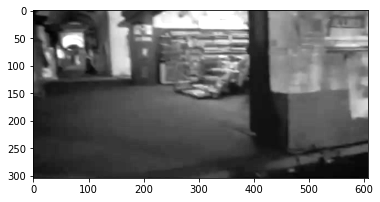

In [11]:
# look at first movie frame
plt.imshow(fingerprint_movie[0, :, :], cmap='gray')

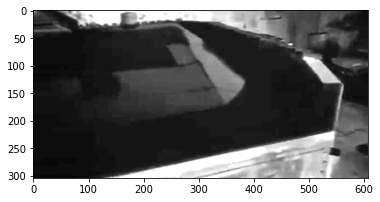

In [12]:
# look at last movie frame
plt.imshow(fingerprint_movie[-1, :, :], cmap='gray')

### find critical parameters for identifying which stimulus display frames the fingerprint movie was shown on

Here is what we expect:
* Each sweep of the fingerprint movie is 30 seconds long
* The movie itself (loaded in file above) was saved at 30Hz 
* 30 second movie clip saved at 30 frames per second = 900 fingerprint movie frames per movie repeat aka sweep
* The movie is intended to be displayed at 60Hz
* To acheive this, each frame of the movie is displayed for 2 stimulus frames, which should give 1800 stimulus display frames per movie sweep
* There are 10 sweeps of the movie
* There should be 18000 total stimulus display frames for the 10 sweeps of the movie

In [13]:
# actual fingerprint movie frame rate
1/df['items']['behavior']['items']['fingerprint']['static_stimulus']['frame_length']

30.0

In [14]:
# desired movie display rate 
df['items']['behavior']['items']['fingerprint']['static_stimulus']['fps']

60.0

In [15]:
# duration of each sweep, in seconds
1/df['items']['behavior']['items']['fingerprint']['static_stimulus']['sweep_length']

30.0

In [16]:
# number of repeats (aka 'sweeps') of the movie
df['items']['behavior']['items']['fingerprint']['static_stimulus']['runs']

10

In [17]:
# Let's save the relevant component of the file to a simpler variable
fingerprint_stim = df['items']['behavior']['items']['fingerprint']['static_stimulus']

In [18]:
fingerprint_stim.keys()

dict_keys(['save_sweep_table', 'shuffle', 'frame_list', 'movie_local_path', 'blank_length', 'stim_path', 'stim', 'stim_text', 'config_path', 'sweep_table', 'on_draw', 'stop_time', 'fps', 'current_frame', 'sweep_frames', 'blank_sweeps', 'unpickleable', 'start_time', 'frame_length', 'dimnames', 'runs', 'total_frames', 'sweep_order', 'sweep_params', 'stim_config', 'movie_path', 'display_sequence', 'sweep_length'])

`sweep_order` tells the order of fingerprint movie frames across sweeps

In [19]:
# This is the order of the fingerprint movie frames that were played
print('"sweep_order" indicates the order of the frames in the fingerprint movie that were played')
print('but there are', len(np.unique(np.asarray(fingerprint_stim['sweep_order']))), 'unique fingerprint movie frames in "sweep_order"',
      '(the same number as the size of the movie loaded above)')
print('total length of "sweep_order" is', len(fingerprint_stim['sweep_order']), ', corresponding to 10 repeats of the 900 frame fingerprint movie')
print('first 10 fingerprint movie frames that were played', fingerprint_stim['sweep_order'][:10])
print('last 10 fingerprint movie frames that were played', fingerprint_stim['sweep_order'][-10:])

"sweep_order" indicates the order of the frames in the fingerprint movie that were played
but there are 900 unique fingerprint movie frames in "sweep_order" (the same number as the size of the movie loaded above)
total length of "sweep_order" is 9000 , corresponding to 10 repeats of the 900 frame fingerprint movie
first 10 fingerprint movie frames that were played [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
last 10 fingerprint movie frames that were played [890, 891, 892, 893, 894, 895, 896, 897, 898, 899]


`sweep_frames` links `sweep_order` to stimulus display frames

In [20]:
# This indiates which stimulus display frames correspond to each movie frame in `sweep_order`
print('"sweep_frames" maps frames of the fingerprint movie to stimulus display frames')
print('total length of "sweep_frames" is', len(fingerprint_stim['sweep_frames']), 'which is the total number of fingerprint movie frames across 10 sweps')
print('the number of unique "sweep_frames" is', len(np.unique(np.asarray(fingerprint_stim['sweep_frames']))), 
     'because each movie frame is presented for 2 stimulus display frames')
print('first 5 sweep_frames', fingerprint_stim['sweep_frames'][:5])
print('last 5 sweep_frames', fingerprint_stim['sweep_frames'][-5:])
print('each pair of frames in each element of "sweep_frames" corresponds to the 2 stimulus display frames for each movie frame')

"sweep_frames" maps frames of the fingerprint movie to stimulus display frames
total length of "sweep_frames" is 9000 which is the total number of fingerprint movie frames across 10 sweps
the number of unique "sweep_frames" is 18000 because each movie frame is presented for 2 stimulus display frames
first 5 sweep_frames [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
last 5 sweep_frames [(17990, 17991), (17992, 17993), (17994, 17995), (17996, 17997), (17998, 17999)]
each pair of frames in each element of "sweep_frames" corresponds to the 2 stimulus display frames for each movie frame


### Importantly, there is also a 5 min gray screen period before the movie starts

In [21]:
print('There are', fingerprint_stim['total_frames'], 'total frames in the fingerprint stimulus block...')

There are 36000 total frames in the fingerprint stimulus block...


because there is also a 5 minute gray screen period before the fingerprint stimulus starts

In [22]:
# movie starts after a 5 minute gray screen period (300 seconds)
fingerprint_stim['start_time']

300.0

There is some critical information one level up in the pkl file to interpret all this...

### `frame_indices` is the bit that pulls it all together

`frame indices` contains the actual stimulus display frame indices corresponding to each frame of the gray screen + fingerprint movie block

In [23]:
# frames where fingerprint movie and preceeding gray screen were played
df['items']['behavior']['items']['fingerprint']['frame_indices']

array([234034, 234035, 234036, ..., 270031, 270032, 270033], dtype=uint32)

In [24]:
# total number of frames for fingerprint movie and preceeding gray screen
print('the length of "frame_indices" is', len(df['items']['behavior']['items']['fingerprint']['frame_indices']), 
      'which is the same number listed above in the "total_frames" key')

the length of "frame_indices" is 36000 which is the same number listed above in the "total_frames" key


300 second movie start time * 60 frames per second display rate = movie should start at 18000 frames into this block

In [25]:
start_time = fingerprint_stim['start_time']
print(start_time, 'movie stim start time')

300.0 movie stim start time


In [26]:
monitor_frame_rate = df['items']['behavior']['stim_config']['fps']
print(monitor_frame_rate, 'Hz stimulus display rate')

60.0 Hz stimulus display rate


In [27]:
movie_start_index = int(start_time*monitor_frame_rate)-1 # account for zero indexing
print(movie_start_index)

17999


In [28]:
frame_indices = df['items']['behavior']['items']['fingerprint']['frame_indices']
movie_start_frame = frame_indices[movie_start_index]
print('movie should start on stimulus display frame ', movie_start_frame)

movie should start on stimulus display frame  252033


In [29]:
n_repeats = df['items']['behavior']['items']['fingerprint']['static_stimulus']['runs']
print(n_repeats)

10


In [30]:
print('final stimulus display frame minus movie start time gives', frame_indices[-1]-movie_start_frame, 'frames', 
      'which is the length of', n_repeats ,'repeats of a', 
      len(np.unique(np.asarray(fingerprint_stim['sweep_frames']))), 'frame long movie stimulus')

final stimulus display frame minus movie start time gives 18000 frames which is the length of 10 repeats of a 18000 frame long movie stimulus
